# Effects of recursivity and autocorrelated noise in timeseries analysis

This notebook simulates data to understand the effects of recursivity and autocorrelated noise on estimating parameters in timeseries analyses.

Recursivity is the extent to which each time point in the timeseries **data** depends on previous timepoints.  

Autocorrelated noise is the extent to which the residuals/**error** from the predictions of a linear model depend on residuals from previous time points. This violates the assumption of normally distributed IID errors in the linear regression framework.  

In this notebook we generate data that mimmicks the time course of a single node (in a neural network) in response to a block design task. Two parameters control the amount of recursivity in the data and autocorrelation in the residuals. We recover the recursivity parameter on simulated data both with and without accounting for autocorrelated noise. The "task regressor" coefficient is defined with respect to the recursivity parameter so this exercise gives us an idea of the impact of not accounting for autocorrelated noise in GLMs with real data.  

First we set up our environment.

In [1]:
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARMA

def pshift(y,p):
    y_lag = np.roll(y, p)
    y_lag[:p] = 0
    return y_lag

In [2]:
sys.path.append('../')
sys.path.append('../../utils/')

# Primary module with most model functions
from model import hrf, convolveTimeseries

Our task is a block design that goes on for 500 ms and comes on for 10 ms every 15 ms after the first block at 11 ms. In total there are 20 events/blocks. Below is the first 100 ms.

Text(0.5, 1.0, 'Convolved')

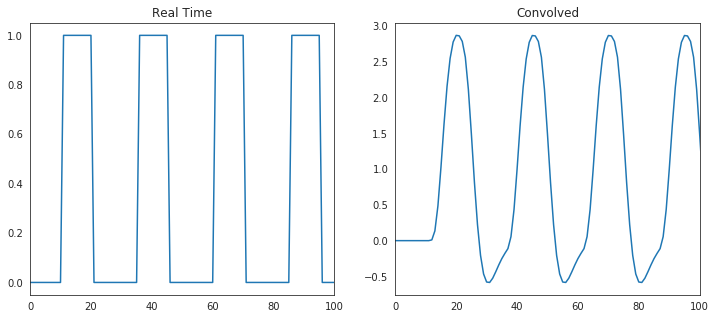

In [3]:
T = np.arange(0,500,1)
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%25>10 and t%25<21:
        tasktiming[0,t] = 1.0


plt.rcParams["figure.figsize"][0] = 12
plt.rcParams["figure.figsize"][1] = 5
fig, (ax1,ax2) = plt.subplots(1, 2)

        
ax1.plot(T, tasktiming[0])
ax1.set_xlim(0,100)
ax1.set_title("Real Time")
ax2.plot(T, convolveTimeseries(tasktiming, TRLength=1)[0])
ax2.set_xlim(0,100)
ax2.set_title("Convolved")

We define the data generating process in `make_y` as:

\begin{equation*}
y(t) = \phi y(t-1) + (1-\phi)x(t) + \epsilon(t)
\end{equation*}

where $\phi$ is the recursivity parameter determining the effect of the previous time point on the current time point.  

$x(t)$ is the task regressor where its effect on the data/timeseries is linked (for exercise purposes, albeit unrealistically for real data) to the recursivity parameter.  

$\epsilon$ is the autocorrelated error defined as 

\begin{equation*}
\epsilon(t) = \rho \epsilon(t-1) + v(t)
\end{equation*}

where $\rho$ determines the degree to which the error term from the previous time point affects the error terms in the current time point. $v(t)$ is IID and in line with regression assumptions.

## Accounting for autocorrelated noise

This is done by eliminating the effect of $\epsilon$ in the estimation of $\phi$. We start by substituting the error term in the original equation 

\begin{equation*}
y(t) = \phi y(t-1) + (1-\phi)x(t) + \rho \epsilon(t-1) + v(t)
\end{equation*}

where

\begin{equation*}
\epsilon(t-1) = y(t-1) - \phi y(t-2) - (1-\phi)x(t-1)
\end{equation*}

so to remove $\epsilon$ from the estimation of $y(t)$ where the only error terms left the IID $v(t)$ we rewrite the equation as:  

\begin{equation*}
y(t) = \phi y(t-1) + (1-\phi)x(t) + \rho (y(t-1) - \phi y(t-2) - (1-\phi)x(t-1)) + v(t)
\end{equation*}

which can be rearranged as:  
\begin{equation*}
y(t) = \phi y(t-1) + (1-\phi)x(t) + \rho y(t-1) - \rho\phi y(t-2) - \rho(1-\phi)x(t-1) + v(t)  
\end{equation*}


\begin{equation*}
y(t) = (\phi+\rho) y(t-1)  - \rho\phi y(t-2) + (1-\phi)x(t) - \rho(1-\phi)x(t-1) + v(t)
\end{equation*}

Modeling $y(t)$ directly in this manner is one way to account for the effect of autocorrelation.   

In this method $\beta_1$ would give an estimate of $(\phi+\rho)$, $\beta_2$ of $\rho\phi$ and $\beta_3$ would yield a un-/less biased estimate of $(1-\phi)$

Note: The other coefficients from this model could/should also yield better estimates of $\phi$ but since we don't know the true $\rho$ in the estimation step (as opposed to the simulation step) and instead estimate it as $\hat{\rho}$ using the residuals from the uncorrected model using the other coefficients to estimate a corrected $\phi$ would depend on the how well $\hat{\rho}$ is estimated. This plays a more important role below.


## Prewhitening

The above equation can be rewritten as 

\begin{equation*}
y(t) - \rho y(t-1) = \phi y(t-1) + (1-\phi)x(t)  - \rho(\phi y(t-2) + (1-\phi)x(t-1)) + v(t)  
\end{equation*}

which clarifies the effect of "prewhitening" as detailed [here](https://newonlinecourses.science.psu.edu/stat510/lesson/8/8.1).

Modelling $y(t)$ directly accounting for the effect of autocorrelation as described above without transforming the data could be trickier to derive for more complicated models. This rearrangement of the equation makes the generalized procedure behind 'prewhitening' clearer: transforming both the outcome measure as well as the design matrix by subtracting out the effect of autocorrelation ($\rho$) for the time steps it is modeled to affect (i.e. the $p$ in the $AR(p)$ model).

For computational efficiency the above operations can be done in matrix form as well. The steps for this are translated from [this blog post by Mandy Mejia](https://mandymejia.com/2016/11/06/how-to-efficiently-prewhiten-fmri-timeseries-the-right-way/) to estimate a voxelwise prewhitening matrix $W$ and rerun the regression $Wy = WX\beta + W\epsilon$ in the `whiten` function.


**These two ways of accounting for autocorrelated noise (i.e. modeling $y(t)$ directly versus prewhitening using the $W$ matrix) differ in one crucial aspect: the estimation of the autocorrelation. In the former method $\rho$ is not estimated directly while it is necessary to do so using an $AR(p)$ model in the latter method. Therefore the latter method should depend on how well $\rho$ can be recovered**

## Simulations

In [18]:
def make_y(x, phi, rho, mu=0, sigma=1):
    y = np.zeros(len(x))
    
    noise = np.random.normal(mu, sigma, len(y))
    
    for i in range(len(y)):
        if i == 0:
            y[i] = copy.copy(x[i])
        else:
            noise[i] = rho*noise[i-1]+noise[i]
            y[i] = phi*y[i-1]+(1-phi)*x[i]+noise[i]
    
    out = {'y' : y,
          'noise' : noise}        
    #return(y)
    return(out)

### Prewhitening example

To understand the effect of prewhitening on estimating relationships (i.e. reduction of false positives) between two timeseries we compare the change in task related parameter estimate (1-$\phi$) with and without prewhitening datasets generated with and without autocorrelated noise.

We generate two datasets with the same autorecurisivity parameter ($\phi$) and different noise distributions. `Data with autocorrelated noise` has a $\rho$>0 while `data with random noise` has a $\rho$ of 0.

In [6]:
phi_stim = 0.5
rho_stim = 0.9
x = convolveTimeseries(tasktiming, TRLength=1)[0]

data_cornoise = make_y(x, phi_stim, rho_stim)
data_randnoise = make_y(x, phi_stim, 0)

df = pd.DataFrame({"y_cornoise": data_cornoise['y'],
                   "y_randnoise": data_randnoise['y'],
                   "lag_y_cornoise": np.r_[0, data_cornoise['y'][:-1]],
                   "lag_y_randnoise": np.r_[0, data_randnoise['y'][:-1]],
                   "cornoise": data_cornoise['noise'],
                   "randnoise": data_randnoise['noise'],
                   "lag_cornoise": np.r_[0, data_cornoise['noise'][:-1]],
                   "lag_randnoise": np.r_[0, data_randnoise['noise'][:-1]],
                   "x": x})

In [7]:
df['y_cornoise_sans_x'] = smf.ols(formula="y_cornoise ~ -1 + x", data=df).fit().resid
df['y_randnoise_sans_x'] = smf.ols(formula="y_randnoise ~ -1 + x", data=df).fit().resid
df['y_cornoise_sans_ylag'] = smf.ols(formula="y_cornoise ~ -1 + lag_y_cornoise", data=df).fit().resid
df['y_randnoise_sans_ylag'] = smf.ols(formula="y_randnoise ~ -1 + lag_y_randnoise", data=df).fit().resid

tru_cornoise = smf.ols(formula="cornoise ~ -1 + lag_cornoise", data=df).fit()
tru_randnoise = smf.ols(formula="randnoise ~ -1 + lag_randnoise", data=df).fit()

m1_cornoise = smf.ols(formula="y_cornoise ~ -1 + lag_y_cornoise + x", data=df).fit()
m1_randnoise = smf.ols(formula="y_randnoise ~ -1 + lag_y_randnoise + x", data=df).fit()

df['pred_y_cornoise'] = m1_cornoise.predict()
df['pred_y_randnoise'] = m1_randnoise.predict()

df['pred_cornoise'] = m1_cornoise.resid
df['pred_randnoise'] = m1_randnoise.resid

df["lag_pred_cornoise"] = np.r_[0, m1_cornoise.resid[:-1]]
df["lag_pred_randnoise"] = np.r_[0, m1_randnoise.resid[:-1]]

#AR models - estimating the lagged correlation in the residuals of m1's
pred_rho_cornoise = smf.ols(formula="pred_cornoise ~ -1 + lag_pred_cornoise", data=df).fit()
pred_rho_randnoise = smf.ols(formula="pred_randnoise ~ -1 + lag_pred_randnoise", data=df).fit()

#Remove effect of estimated autocorrelation from DV and IVs
df['pw_y_cornoise'] = df['y_cornoise'] - pred_rho_cornoise.params[0]*df['lag_y_cornoise']
df['pw_y_randnoise'] = df['y_randnoise'] - pred_rho_cornoise.params[0]*df['lag_y_randnoise']
df['pw_lag_y_cornoise'] = np.r_[0, df['pw_y_cornoise'][:-1]]
df['pw_lag_y_randnoise'] = np.r_[0, df['pw_y_randnoise'][:-1]]
df['pw_x']= df['x'] - pred_rho_cornoise.params[0]*np.r_[0, df['x'][:-1]]

#Run model between timeseries of prewhitened data
pwm_cornoise = smf.ols(formula="pw_y_cornoise ~ -1 + pw_lag_y_cornoise + pw_x", data=df).fit()
pwm_randnoise = smf.ols(formula="pw_y_randnoise ~ -1 + pw_lag_y_randnoise + pw_x", data=df).fit()

df['pred_pw_y_cornoise'] = pwm_cornoise.predict()
df['pred_pw_y_randnoise'] = pwm_randnoise.predict()

df['pred_pw_cornoise'] = pwm_cornoise.resid
df['pred_pw_randnoise'] = pwm_randnoise.resid

What does autocorrelated noise look like?  

[Coding check] Can the parameter used to generate the autocorrelated noise be recovered regressing the true noise on the lagged noise? Yes.

True rho for correlated noise= 0.9 ; estimated rho for correlated noise = 0.91
True rho for random noise= 0 ; estimated rho for random noise = -0.01
Black line is the unit line


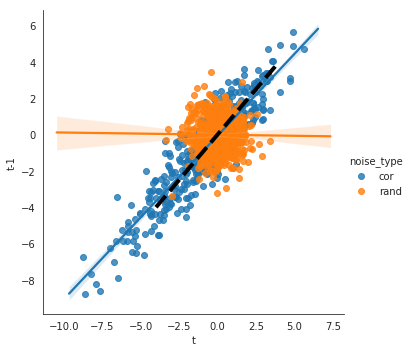

In [8]:
tmp1 = df[['cornoise', "lag_cornoise"]]
tmp1 = tmp1.rename(columns={"cornoise": "t", "lag_cornoise": "t-1"})
tmp1['noise_type'] = "cor"
tmp1['est_cor'] = tru_cornoise.params[0]
tmp2 = df[['randnoise', "lag_randnoise"]]
tmp2 = tmp2.rename(columns={"randnoise": "t", "lag_randnoise": "t-1"})
tmp2['noise_type'] = "rand"
tmp2['est_cor'] = tru_randnoise.params[0]

df_m = tmp1.append(tmp2, ignore_index=True)
df_m.reset_index
df_m.head()

sns.lmplot(data = df_m, x = 't', y = 't-1', hue = 'noise_type')
plt.plot([-4, 4], [-4, 4], linewidth=4, color = "black", linestyle = "--")
print("True rho for correlated noise= %s ; estimated rho for correlated noise = %s"%(str(rho_stim), str(round(tru_cornoise.params[0],2))))
print("True rho for random noise= %s ; estimated rho for random noise = %s"%(str(0), str(round(tru_randnoise.params[0],2))))
print("Black line is the unit line")

What is the effect of autocorrelated noise on the (observable) data:
- the task regressor (underestimation)
- the recursiveness (overestimation)


True task regressor: 0.5
True recursivity: 0.5
Plotting residualized effects (i.e. the effect of x is taken out from the effect of ylag)
Red lines indicate 'true' relationship


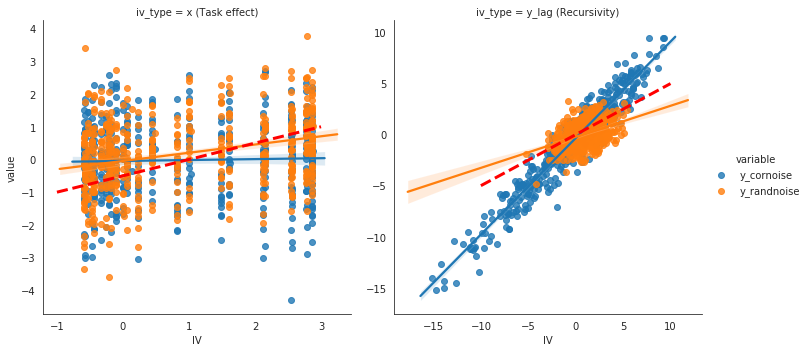

In [9]:
print("True task regressor: %s"%(str(1-phi_stim)))
print("True recursivity: %s"%(str(phi_stim)))
print("Plotting residualized effects (i.e. the effect of x is taken out from the effect of ylag)")
print("Red lines indicate 'true' relationship")

df_m = df[['x', 'y_cornoise_sans_ylag', 'y_randnoise_sans_ylag']]
df_m = pd.melt(df_m, id_vars = ["x"], value_vars = ["y_cornoise_sans_ylag", "y_randnoise_sans_ylag"])
df_m = df_m.rename(columns = {"x": "IV"})
df_m['iv_type'] = "x (Task effect)"
df_m['variable']=df_m.variable.str.replace('_sans_ylag','')

tmp1 = df[['y_cornoise_sans_x', 'lag_y_cornoise']]
tmp1 = tmp1.rename(columns = {'y_cornoise_sans_x': 'value', 'lag_y_cornoise': 'IV'})
tmp1['variable'] = "y_cornoise"
tmp1['iv_type'] = "y_lag (Recursivity)"
tmp2 = df[['y_randnoise_sans_x', 'lag_y_randnoise']]
tmp2 = tmp2.rename(columns = {'y_randnoise_sans_x': 'value', 'lag_y_randnoise': 'IV'})
tmp2['variable'] = "y_randnoise"
tmp2['iv_type'] = "y_lag (Recursivity)"

tmp3 = df_m.append(tmp1, ignore_index = True, sort=False)
tmp3 = tmp3.append(tmp2, ignore_index = True, sort=False)

g = sns.lmplot(x = "IV", y = "value", hue = "variable", col = "iv_type", data = tmp3, sharex = False, sharey=False)

g.axes[0, 0].plot((-1, 3), (-1, 1), 'k--', linewidth=3, color= 'red')
g.axes[0, 1].plot((-10, 10), (-5, 5), 'k--', linewidth=3, color= 'red')

In [10]:
print("True task regressor: %s"%(str(1-phi_stim)))
a = np.corrcoef(tmp3.query('iv_type == "x (Task effect)" & variable == "y_cornoise"')[['value','IV']].T)[0,1]
print("Empirical residualized r with task regressor with autocorrelated noise: %s"%(str(round(a,2))))
a = np.corrcoef(tmp3.query('iv_type == "x (Task effect)" & variable == "y_randnoise"')[['value','IV']].T)[0,1]
print("Empirical residualized r with task regressor without autocorrelated noise: %s"%(str(round(a,2))))

print("True recursivity: %s"%(str(phi_stim)))
a = np.corrcoef(tmp3.query('iv_type != "x (Task effect)" & variable == "y_cornoise"')[['value','IV']].T)[0,1]
print("Empirical residualized r with lagged DV with autocorrelated noise: %s"%(str(round(a,2))))
a = np.corrcoef(tmp3.query('iv_type != "x (Task effect)" & variable == "y_randnoise"')[['value','IV']].T)[0,1]
print("Empirical residualized r with lagged DV without autocorrelated noise: %s"%(str(round(a,2))))


True task regressor: 0.5
Empirical residualized r with task regressor with autocorrelated noise: 0.03
Empirical residualized r with task regressor without autocorrelated noise: 0.29
True recursivity: 0.5
Empirical residualized r with lagged DV with autocorrelated noise: 0.96
Empirical residualized r with lagged DV without autocorrelated noise: 0.42


Prewhitening success should depend on how much the residuals of the first model resemble the noise used in data generation.

**Note that how well the model recovers the true autocorrelation is not the same thing as how well the model fits the data!** In fact, comparing the model predicted values to true data we find that the model fits better for data generated with correlated noise. The addition of correlated noise amplifies the relationship between the IV and DV.

To highlight this difference below we plot the predicted values against the true values for both the data (left) *and* the residuals (right) from the models.

Blakc lines are unit lines


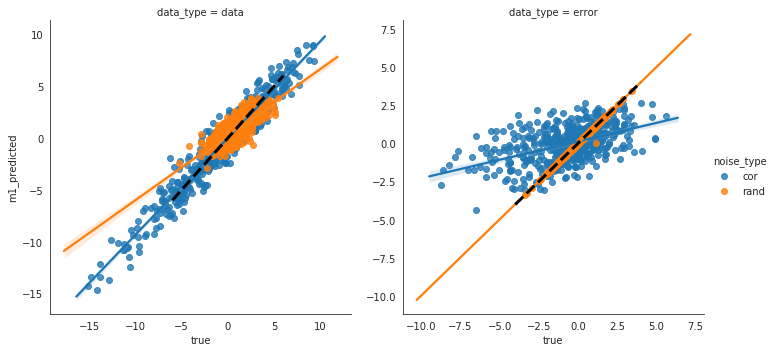

In [11]:
tmp1 = df[['y_cornoise', 'pred_y_cornoise']]
tmp1 = tmp1.rename(columns={"y_cornoise": "true", "pred_y_cornoise": "m1_predicted"})
tmp1['noise_type'] = "cor"

tmp2 = df[['y_randnoise', 'pred_y_randnoise']]
tmp2 = tmp2.rename(columns={"y_randnoise": "true", "pred_y_randnoise": "m1_predicted"})
tmp2['noise_type'] = "rand"

df_m = tmp1.append(tmp2, ignore_index=True)
df_m.reset_index
df_m['data_type'] = "data"

tmp1 = df[['cornoise', 'pred_cornoise']]
tmp1 = tmp1.rename(columns={"cornoise": "true", "pred_cornoise": "m1_predicted"})
tmp1['noise_type'] = "cor"
tmp2 = df[['randnoise', 'pred_randnoise']]
tmp2 = tmp2.rename(columns={"randnoise": "true", "pred_randnoise": "m1_predicted"})
tmp2['noise_type'] = "rand"

df_m2 = tmp1.append(tmp2, ignore_index=True)
df_m2.reset_index
df_m2['data_type'] = "error"
df_m = df_m.append(df_m2, ignore_index=True)

#df_m['data_type'] = np.where(df_m['data_type'] == "")
g=sns.lmplot(data = df_m, x = 'true', y = 'm1_predicted', col = "data_type", hue = 'noise_type', sharex = False, sharey = False)
g.axes[0, 0].plot((-6, 6), (-6, 6), 'k--', linewidth=3)
g.axes[0, 1].plot((-4, 4), (-4, 4), 'k--', linewidth=3)
print("Blakc lines are unit lines")


The left graph above can be confusing. It shows that the model fits better for data with correlated noise compared to data with random noise (ie. the predictions from that model are closer to the true values).  

This is because the relationship between one of the regressors (ylag) and the DV in the **data** is amplified with the addition of correlated noise. By pushing most of the variance on this regressor the model can do a decent job in explaining much of the variance in the data and thus generate predictions that are close to the truth in the data.  

Since this relationship is contaminated by the autocorrelation, however, capturing it without accounting for the confounder is misleading.  

The coefficients below suggest that the estimate is much closer to the true value for data with random noise and overestimates for data with correlated noise.

In [12]:
print("True phi for data with correlated noise = %s ; estimated phi for correlated noise = %s"%(str(phi_stim), str(round(m1_cornoise.params[0],2))))
print("True phi for data with random noise = %s ; estimated phi for random noise = %s"%(str(phi_stim), str(round(m1_randnoise.params[0],2))))

True phi for data with correlated noise = 0.5 ; estimated phi for correlated noise = 0.97
True phi for data with random noise = 0.5 ; estimated phi for random noise = 0.51


What is the estimated autocorrelation in the residuals from the first model?

In [13]:
print("True rho for correlated noise = %s ; estimated rho for correlated noise = %s"%(str(rho_stim), str(round(pred_rho_cornoise.params[0],2))))
print("True rho for random noise = %s ; estimated rho for random noise = %s"%(str(0), str(round(pred_rho_randnoise.params[0],2))))

True rho for correlated noise = 0.9 ; estimated rho for correlated noise = 0.46
True rho for random noise = 0 ; estimated rho for random noise = -0.02


The GLM assumes that the residuals of the model estimated on data generated with autocorrelated noise should be normal and IID. The estimated $\rho$ above and the plot below shows that the estimated autocorrelation is therefore smaller than the true value.   

Though the model does not estimate the autocorrelation to be 0 how far it is from the true $\rho$ (i.e. the difference between the two distributions on the left plot below) will impact the success of prewhitening and the improvement in estimating $\phi$.

Plotting the autocorrelation in true noise overlaid with the autocorrelation in the model residuals
Black lines are unit lines


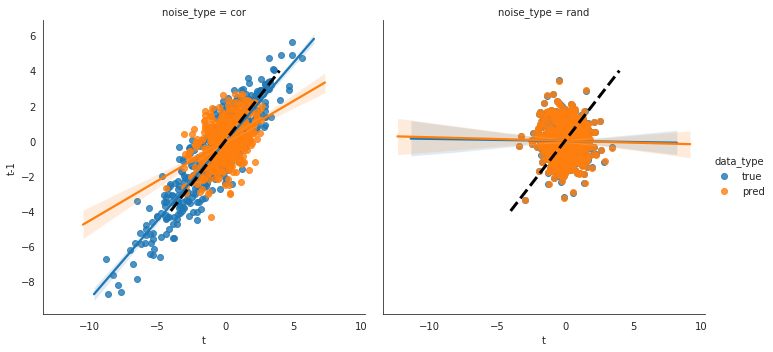

In [15]:
tmp1 = df[['cornoise', 'lag_cornoise']]
tmp1 = tmp1.rename(columns = {'cornoise': "t", 'lag_cornoise': "t-1"})
tmp1['data_type'] = "true"
tmp1['noise_type'] = "cor"

tmp2 = df[['randnoise', 'lag_randnoise']]
tmp2 = tmp2.rename(columns = {'randnoise': "t", 'lag_randnoise': "t-1"})
tmp2['data_type'] = "true"
tmp2['noise_type'] = "rand"

tmp3 = df[['pred_cornoise', 'lag_pred_cornoise']]
tmp3 = tmp3.rename(columns = {'pred_cornoise': "t", 'lag_pred_cornoise':"t-1"})
tmp3['data_type'] = "pred"
tmp3['noise_type'] = "cor"

tmp4 = df[['pred_randnoise', 'lag_pred_randnoise']]
tmp4 = tmp4.rename(columns = {'pred_randnoise':"t", 'lag_pred_randnoise':"t-1"})
tmp4['data_type'] = "pred"
tmp4['noise_type'] = "rand"

df_m = tmp1.append(tmp2, ignore_index=True)
df_m = df_m.append(tmp3, ignore_index=True)
df_m = df_m.append(tmp4, ignore_index=True)
df_m.reset_index()

g=sns.lmplot(data = df_m, x = 't', y = 't-1', col = "noise_type", hue = 'data_type')

g.axes[0, 0].plot((-4, 4), (-4, 4), 'k--', linewidth=3)
g.axes[0, 1].plot((-4, 4), (-4, 4), 'k--', linewidth=3)

print("Plotting the autocorrelation in true noise overlaid with the autocorrelation in the model residuals")
print("Black lines are unit lines")

How successful is prewhitening with this underestimated autocorrelation?  

Prewhitening leads to a small correction of the estimated in data with correlated noise. The 'corrected' estimate is still very far from the true value.  

For data with random noise prewhitening turns the to just noise and the destroys the true relationship.

In [16]:
print("True phi for data with correlated noise = %s"%(str(phi_stim)))
print("Estimated phi for data with correlated noise without prewhitening = %s"%(str(round(m1_cornoise.params[0],2))))
print("Estimated phi for data with correlated noise with prewhitening = %s"%(str(round(pwm_cornoise.params[0],2))))

print("True phi for data with random noise = %s"%(str(phi_stim)))
print("Estimated phi for data with random noise without prewhitening = %s"%(str(round(m1_randnoise.params[0],2))))
print("Estimated phi for data with random noise with prewhitening = %s"%(str(round(pwm_randnoise.params[0],2))))


True phi for data with correlated noise = 0.5
Estimated phi for data with correlated noise without prewhitening = 0.97
Estimated phi for data with correlated noise with prewhitening = 0.92
True phi for data with random noise = 0.5
Estimated phi for data with random noise without prewhitening = 0.51
Estimated phi for data with random noise with prewhitening = 0.09


In [17]:
df_org = copy.copy(df)

#### Prewhitening with more parameters

What if the task regressor was an independent parameter? (ie. effect of $x$ is not (1-$\phi$) but some other parameter)?

\begin{equation*}
y(t) = \phi y(t-1) + \tau x(t) + \epsilon(t)
\end{equation*}

In [19]:
def make_y_ind_x(x, phi, rho, tau, mu=0, sigma=1):
    y = np.zeros(len(x))
    
    noise = np.random.normal(mu, sigma, len(y))
    
    for i in range(len(y)):
        if i == 0:
            y[i] = copy.copy(x[i])
        else:
            noise[i] = rho*noise[i-1]+noise[i]
            y[i] = phi*y[i-1]+tau*x[i]+noise[i]
    
    out = {'y' : y,
          'noise' : noise}        
    #return(y)
    return(out)

In [22]:
tau_stim = 0.7

data_cornoise = make_y_ind_x(x, phi_stim, rho_stim, tau_stim)
data_randnoise = make_y_ind_x(x, phi_stim, 0, tau_stim)

df = pd.DataFrame({"y_cornoise": data_cornoise['y'],
                   "y_randnoise": data_randnoise['y'],
                   "lag_y_cornoise": np.r_[0, data_cornoise['y'][:-1]],
                   "lag_y_randnoise": np.r_[0, data_randnoise['y'][:-1]],
                   "cornoise": data_cornoise['noise'],
                   "randnoise": data_randnoise['noise'],
                   "lag_cornoise": np.r_[0, data_cornoise['noise'][:-1]],
                   "lag_randnoise": np.r_[0, data_randnoise['noise'][:-1]],
                   "x": x})

df['y_cornoise_sans_x'] = smf.ols(formula="y_cornoise ~ -1 + x", data=df).fit().resid
df['y_randnoise_sans_x'] = smf.ols(formula="y_randnoise ~ -1 + x", data=df).fit().resid
df['y_cornoise_sans_ylag'] = smf.ols(formula="y_cornoise ~ -1 + lag_y_cornoise", data=df).fit().resid
df['y_randnoise_sans_ylag'] = smf.ols(formula="y_randnoise ~ -1 + lag_y_randnoise", data=df).fit().resid

tru_cornoise = smf.ols(formula="cornoise ~ -1 + lag_cornoise", data=df).fit()
tru_randnoise = smf.ols(formula="randnoise ~ -1 + lag_randnoise", data=df).fit()

m1_cornoise = smf.ols(formula="y_cornoise ~ -1 + lag_y_cornoise + x", data=df).fit()
m1_randnoise = smf.ols(formula="y_randnoise ~ -1 + lag_y_randnoise + x", data=df).fit()

df['pred_y_cornoise'] = m1_cornoise.predict()
df['pred_y_randnoise'] = m1_randnoise.predict()

df['pred_cornoise'] = m1_cornoise.resid
df['pred_randnoise'] = m1_randnoise.resid

df["lag_pred_cornoise"] = np.r_[0, m1_cornoise.resid[:-1]]
df["lag_pred_randnoise"] = np.r_[0, m1_randnoise.resid[:-1]]

#AR models - estimating the lagged correlation in the residuals of m1's
pred_rho_cornoise = smf.ols(formula="pred_cornoise ~ -1 + lag_pred_cornoise", data=df).fit()
pred_rho_randnoise = smf.ols(formula="pred_randnoise ~ -1 + lag_pred_randnoise", data=df).fit()

#Remove effect of estimated autocorrelation from DV and IVs
df['pw_y_cornoise'] = df['y_cornoise'] - pred_rho_cornoise.params[0]*df['lag_y_cornoise']
df['pw_y_randnoise'] = df['y_randnoise'] - pred_rho_cornoise.params[0]*df['lag_y_randnoise']
df['pw_lag_y_cornoise'] = np.r_[0, df['pw_y_cornoise'][:-1]]
df['pw_lag_y_randnoise'] = np.r_[0, df['pw_y_randnoise'][:-1]]
df['pw_x']= df['x'] - pred_rho_cornoise.params[0]*np.r_[0, df['x'][:-1]]

#Run model between timeseries of prewhitened data
pwm_cornoise = smf.ols(formula="pw_y_cornoise ~ -1 + pw_lag_y_cornoise + pw_x", data=df).fit()
pwm_randnoise = smf.ols(formula="pw_y_randnoise ~ -1 + pw_lag_y_randnoise + pw_x", data=df).fit()

df['pred_pw_y_cornoise'] = pwm_cornoise.predict()
df['pred_pw_y_randnoise'] = pwm_randnoise.predict()

df['pred_pw_cornoise'] = pwm_cornoise.resid
df['pred_pw_randnoise'] = pwm_randnoise.resid

What does autocorrelated noise look like?  

[Coding check] Can the parameter used to generate the autocorrelated noise be recovered regressing the true noise on the lagged noise? Yes.

True rho for correlated noise= 0.9 ; estimated rho for correlated noise = 0.91
True rho for random noise= 0 ; estimated rho for random noise = 0.02
Black line is the unit line


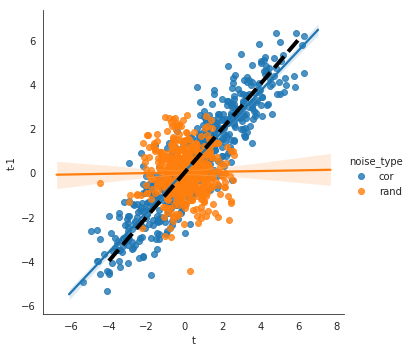

In [24]:
tmp1 = df[['cornoise', "lag_cornoise"]]
tmp1 = tmp1.rename(columns={"cornoise": "t", "lag_cornoise": "t-1"})
tmp1['noise_type'] = "cor"
tmp1['est_cor'] = tru_cornoise.params[0]
tmp2 = df[['randnoise', "lag_randnoise"]]
tmp2 = tmp2.rename(columns={"randnoise": "t", "lag_randnoise": "t-1"})
tmp2['noise_type'] = "rand"
tmp2['est_cor'] = tru_randnoise.params[0]

df_m = tmp1.append(tmp2, ignore_index=True)
df_m.reset_index
df_m.head()

sns.lmplot(data = df_m, x = 't', y = 't-1', hue = 'noise_type')
plt.plot([-4, 6], [-4, 6], linewidth=4, color = "black", linestyle = "--")
print("True rho for correlated noise= %s ; estimated rho for correlated noise = %s"%(str(rho_stim), str(round(tru_cornoise.params[0],2))))
print("True rho for random noise= %s ; estimated rho for random noise = %s"%(str(0), str(round(tru_randnoise.params[0],2))))
print("Black line is the unit line")

What is the effect of autocorrelated noise on the (observable) data:
- the task regressor (underestimation)
- the recursiveness (overestimation)


True task regressor: 0.7
True recursivity: 0.5
Plotting residualized effects (i.e. the effect of x is taken out from the effect of ylag)
Red lines indicate 'true' relationship


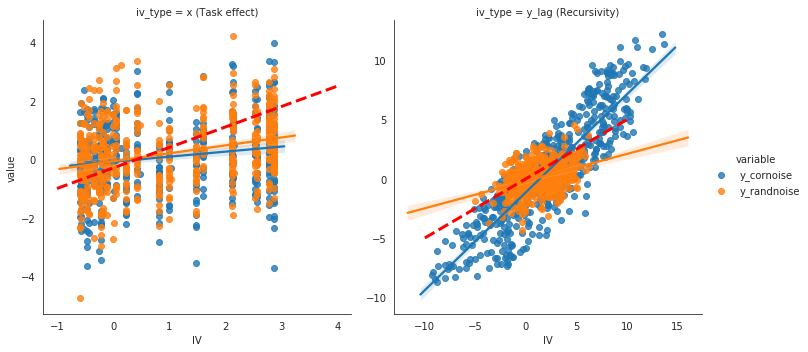

In [26]:
print("True task regressor: %s"%(str(tau_stim)))
print("True recursivity: %s"%(str(phi_stim)))
print("Plotting residualized effects (i.e. the effect of x is taken out from the effect of ylag)")
print("Red lines indicate 'true' relationship")

df_m = df[['x', 'y_cornoise_sans_ylag', 'y_randnoise_sans_ylag']]
df_m = pd.melt(df_m, id_vars = ["x"], value_vars = ["y_cornoise_sans_ylag", "y_randnoise_sans_ylag"])
df_m = df_m.rename(columns = {"x": "IV"})
df_m['iv_type'] = "x (Task effect)"
df_m['variable']=df_m.variable.str.replace('_sans_ylag','')

tmp1 = df[['y_cornoise_sans_x', 'lag_y_cornoise']]
tmp1 = tmp1.rename(columns = {'y_cornoise_sans_x': 'value', 'lag_y_cornoise': 'IV'})
tmp1['variable'] = "y_cornoise"
tmp1['iv_type'] = "y_lag (Recursivity)"
tmp2 = df[['y_randnoise_sans_x', 'lag_y_randnoise']]
tmp2 = tmp2.rename(columns = {'y_randnoise_sans_x': 'value', 'lag_y_randnoise': 'IV'})
tmp2['variable'] = "y_randnoise"
tmp2['iv_type'] = "y_lag (Recursivity)"

tmp3 = df_m.append(tmp1, ignore_index = True, sort=False)
tmp3 = tmp3.append(tmp2, ignore_index = True, sort=False)

g = sns.lmplot(x = "IV", y = "value", hue = "variable", col = "iv_type", data = tmp3, sharex = False, sharey=False)

g.axes[0, 0].plot((-1, 4), (-1, 2.5), 'k--', linewidth=3, color= 'red')
g.axes[0, 1].plot((-10, 10), (-5, 5), 'k--', linewidth=3, color= 'red')

In [27]:
print("True task regressor: %s"%(str(tau_stim)))
a = np.corrcoef(tmp3.query('iv_type == "x (Task effect)" & variable == "y_cornoise"')[['value','IV']].T)[0,1]
print("Empirical residualized r with task regressor with autocorrelated noise: %s"%(str(round(a,2))))
a = np.corrcoef(tmp3.query('iv_type == "x (Task effect)" & variable == "y_randnoise"')[['value','IV']].T)[0,1]
print("Empirical residualized r with task regressor without autocorrelated noise: %s"%(str(round(a,2))))

print("True recursivity: %s"%(str(phi_stim)))
a = np.corrcoef(tmp3.query('iv_type != "x (Task effect)" & variable == "y_cornoise"')[['value','IV']].T)[0,1]
print("Empirical residualized r with lagged DV with autocorrelated noise: %s"%(str(round(a,2))))
a = np.corrcoef(tmp3.query('iv_type != "x (Task effect)" & variable == "y_randnoise"')[['value','IV']].T)[0,1]
print("Empirical residualized r with lagged DV without autocorrelated noise: %s"%(str(round(a,2))))


True task regressor: 0.7
Empirical residualized r with task regressor with autocorrelated noise: 0.18
Empirical residualized r with task regressor without autocorrelated noise: 0.29
True recursivity: 0.5
Empirical residualized r with lagged DV with autocorrelated noise: 0.88
Empirical residualized r with lagged DV without autocorrelated noise: 0.37


Prewhitening success should depend on how much the residuals of the first model resemble the noise used in data generation.

**Note that how well the model recovers the true autocorrelation is not the same thing as how well the model fits the data!** In fact, comparing the model predicted values to true data we find that the model fits better for data generated with correlated noise. The addition of correlated noise amplifies the relationship between the IV and DV.

To highlight this difference below we plot the predicted values against the true values for both the data (left) *and* the residuals (right) from the models.

Blakc lines are unit lines


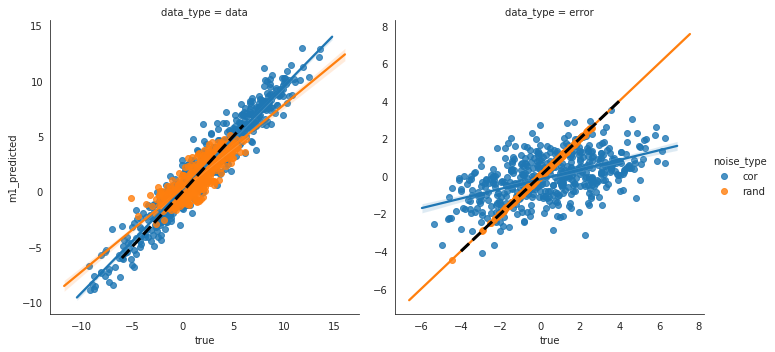

In [28]:
tmp1 = df[['y_cornoise', 'pred_y_cornoise']]
tmp1 = tmp1.rename(columns={"y_cornoise": "true", "pred_y_cornoise": "m1_predicted"})
tmp1['noise_type'] = "cor"

tmp2 = df[['y_randnoise', 'pred_y_randnoise']]
tmp2 = tmp2.rename(columns={"y_randnoise": "true", "pred_y_randnoise": "m1_predicted"})
tmp2['noise_type'] = "rand"

df_m = tmp1.append(tmp2, ignore_index=True)
df_m.reset_index
df_m['data_type'] = "data"

tmp1 = df[['cornoise', 'pred_cornoise']]
tmp1 = tmp1.rename(columns={"cornoise": "true", "pred_cornoise": "m1_predicted"})
tmp1['noise_type'] = "cor"
tmp2 = df[['randnoise', 'pred_randnoise']]
tmp2 = tmp2.rename(columns={"randnoise": "true", "pred_randnoise": "m1_predicted"})
tmp2['noise_type'] = "rand"

df_m2 = tmp1.append(tmp2, ignore_index=True)
df_m2.reset_index
df_m2['data_type'] = "error"
df_m = df_m.append(df_m2, ignore_index=True)

#df_m['data_type'] = np.where(df_m['data_type'] == "")
g=sns.lmplot(data = df_m, x = 'true', y = 'm1_predicted', col = "data_type", hue = 'noise_type', sharex = False, sharey = False)
g.axes[0, 0].plot((-6, 6), (-6, 6), 'k--', linewidth=3)
g.axes[0, 1].plot((-4, 4), (-4, 4), 'k--', linewidth=3)
print("Blakc lines are unit lines")


The left graph above can be confusing. It shows that the model fits better for data with correlated noise compared to data with random noise (ie. the predictions from that model are closer to the true values).  

This is because the relationship between one of the regressors (ylag) and the DV in the **data** is amplified with the addition of correlated noise. By pushing most of the variance on this regressor the model can do a decent job in explaining much of the variance in the data and thus generate predictions that are close to the truth in the data.  

Since this relationship is contaminated by the autocorrelation, however, capturing it without accounting for the confounder is misleading.  

The coefficients below suggest that the estimate is much closer to the true value for data with random noise and overestimates for data with correlated noise.

In [30]:
print("True phi for data with correlated noise = %s ; estimated phi for correlated noise = %s"%(str(phi_stim), str(round(m1_cornoise.params[0],2))))
print("True phi for data with random noise = %s ; estimated phi for random noise = %s"%(str(phi_stim), str(round(m1_randnoise.params[0],2))))

print("True tau for data with correlated noise = %s ; estimated tau for correlated noise = %s"%(str(tau_stim), str(round(m1_cornoise.params[1],2))))
print("True tau for data with random noise = %s ; estimated tau for random noise = %s"%(str(tau_stim), str(round(m1_randnoise.params[1],2))))

True phi for data with correlated noise = 0.5 ; estimated phi for correlated noise = 0.95
True phi for data with random noise = 0.5 ; estimated phi for random noise = 0.51
True tau for data with correlated noise = 0.7 ; estimated tau for correlated noise = 0.18
True tau for data with random noise = 0.7 ; estimated tau for random noise = 0.68


What is the estimated autocorrelation in the residuals from the first model?

In [31]:
print("True rho for correlated noise = %s ; estimated rho for correlated noise = %s"%(str(rho_stim), str(round(pred_rho_cornoise.params[0],2))))
print("True rho for random noise = %s ; estimated rho for random noise = %s"%(str(0), str(round(pred_rho_randnoise.params[0],2))))

True rho for correlated noise = 0.9 ; estimated rho for correlated noise = 0.54
True rho for random noise = 0 ; estimated rho for random noise = 0.0


The GLM assumes that the residuals of the model estimated on data generated with autocorrelated noise should be normal and IID. The estimated $\rho$ above and the plot below shows that the estimated autocorrelation is therefore smaller than the true value.   

Though the model does not estimate the autocorrelation to be 0 how far it is from the true $\rho$ (i.e. the difference between the two distributions on the left plot below) will impact the success of prewhitening and the improvement in estimating $\phi$.

Plotting the autocorrelation in true noise overlaid with the autocorrelation in the model residuals
Black lines are unit lines


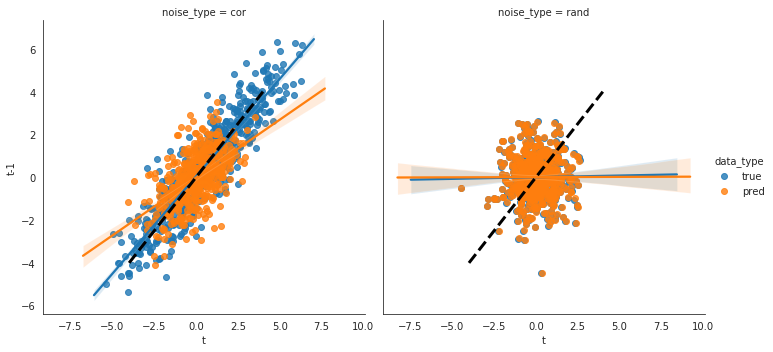

In [32]:
tmp1 = df[['cornoise', 'lag_cornoise']]
tmp1 = tmp1.rename(columns = {'cornoise': "t", 'lag_cornoise': "t-1"})
tmp1['data_type'] = "true"
tmp1['noise_type'] = "cor"

tmp2 = df[['randnoise', 'lag_randnoise']]
tmp2 = tmp2.rename(columns = {'randnoise': "t", 'lag_randnoise': "t-1"})
tmp2['data_type'] = "true"
tmp2['noise_type'] = "rand"

tmp3 = df[['pred_cornoise', 'lag_pred_cornoise']]
tmp3 = tmp3.rename(columns = {'pred_cornoise': "t", 'lag_pred_cornoise':"t-1"})
tmp3['data_type'] = "pred"
tmp3['noise_type'] = "cor"

tmp4 = df[['pred_randnoise', 'lag_pred_randnoise']]
tmp4 = tmp4.rename(columns = {'pred_randnoise':"t", 'lag_pred_randnoise':"t-1"})
tmp4['data_type'] = "pred"
tmp4['noise_type'] = "rand"

df_m = tmp1.append(tmp2, ignore_index=True)
df_m = df_m.append(tmp3, ignore_index=True)
df_m = df_m.append(tmp4, ignore_index=True)
df_m.reset_index()

g=sns.lmplot(data = df_m, x = 't', y = 't-1', col = "noise_type", hue = 'data_type')

g.axes[0, 0].plot((-4, 4), (-4, 4), 'k--', linewidth=3)
g.axes[0, 1].plot((-4, 4), (-4, 4), 'k--', linewidth=3)

print("Plotting the autocorrelation in true noise overlaid with the autocorrelation in the model residuals")
print("Black lines are unit lines")

How successful is prewhitening with this underestimated autocorrelation?  

Prewhitening leads to a small correction of the estimated in data with correlated noise. The 'corrected' estimate is still very far from the true value.  

For data with random noise prewhitening turns the to just noise and the destroys the true relationship.

In [34]:
print("True phi for data with correlated noise = %s"%(str(phi_stim)))
print("Estimated phi for data with correlated noise without prewhitening = %s"%(str(round(m1_cornoise.params[0],2))))
print("Estimated phi for data with correlated noise with prewhitening = %s"%(str(round(pwm_cornoise.params[0],2))))

print("True tau for data with correlated noise = %s"%(str(tau_stim)))
print("Estimated tau for data with correlated noise without prewhitening = %s"%(str(round(m1_cornoise.params[1],2))))
print("Estimated tau for data with correlated noise with prewhitening = %s"%(str(round(pwm_cornoise.params[1],2))))

print('\n')

print("True phi for data with random noise = %s"%(str(phi_stim)))
print("Estimated phi for data with random noise without prewhitening = %s"%(str(round(m1_randnoise.params[0],2))))
print("Estimated phi for data with random noise with prewhitening = %s"%(str(round(pwm_randnoise.params[0],2))))

print("True tau for data with random noise = %s"%(str(tau_stim)))
print("Estimated tau for data with random noise without prewhitening = %s"%(str(round(m1_randnoise.params[1],2))))
print("Estimated tau for data with random noise with prewhitening = %s"%(str(round(pwm_randnoise.params[1],2))))


True phi for data with correlated noise = 0.5
Estimated phi for data with correlated noise without prewhitening = 0.95
Estimated phi for data with correlated noise with prewhitening = 0.88
True tau for data with correlated noise = 0.7
Estimated tau for data with correlated noise without prewhitening = 0.18
Estimated tau for data with correlated noise with prewhitening = 0.29


True phi for data with random noise = 0.5
Estimated phi for data with random noise without prewhitening = 0.51
Estimated phi for data with random noise with prewhitening = 0.06
True tau for data with random noise = 0.7
Estimated tau for data with random noise without prewhitening = 0.68
Estimated tau for data with random noise with prewhitening = 1.21


### Varying $\phi$ and $\rho$ systematically

For $\phi$ and $\rho$ ranging from 0 to 1 with .1 increments simulate recursive data with autocorrelated noise and estimate the recursivity parameter using ordinary least squares with and without accounting for the autocorrelation.

In [5]:
def whiten(mod_obj, p=1, q=0, verbose=False, manual = True):
    
    err = mod_obj.fit().resid
    X = mod_obj.exog
    y = mod_obj.endog
    
    try:
        ar_mod = ARMA(err, order=(p, q))
        ar_res = ar_mod.fit(trend="nc")
        
        first_col = np.insert(-ar_res.params, 0, 1)
        for i in range(len(y)-1):
            if i == 0:
                cur_col = copy.copy(first_col)
                cur_col = np.insert(cur_col, 2, np.zeros(len(y)-len(ar_res.params)-1))
                A = cur_col.reshape(-1,1)
            else:
                cur_col = A[:,i]
            col_lag = np.r_[0, cur_col[:-1]]
            col_lag = col_lag.reshape(-1,1)
            A = np.concatenate((A, col_lag), 1)
            
        V_inv = np.dot(A,A.T)
        
        u, d, vh = np.linalg.svd(V_inv)
        
        W=u.dot(np.sqrt(np.diag(d))).dot(u.T)
            
        Wy = np.dot(W,y)
        WX = np.dot(W,X)
        
        #mod_pw = sm.OLS(Wy, WX)
        #res_pw = mod_pw.fit()
        
        #out = np.insert(ar_res.params, 1, res_pw.params[1])
        
        out = {'Wy': Wy,
              'WX': WX,
              'rho_est': ar_res.params[0]}
        
        if manual == True:
            shift_y = pshift(y, p)
            shift_X = pshift(X, p)
            mpw_y = y - (ar_res.params*shift_y)
            mpw_X = X - (ar_res.params*shift_X)
            #mod_mpw = sm.OLS(mpw_y, mpw_X)
            #res_mpw = mod_mpw.fit()
            #out = np.insert(out, 2, res_mpw.params[1])
            out['mpw_y'] = mpw_y
            out['mpw_X'] = mpw_X

        
    except:
        print("Whitening failed!")
        out = {'Wy': np.nan, 'WX': np.nan, 'mpw_y': np.nan, 'mpw_X': np.nan, 'rho_est': np.nan}
    return(out)

Function to recover the $\phi$ and $\rho$ parameters from either given data or after simulating data.  

Arguments:

`phi_stim`: $\phi$ that will be used if simulating data.  
`rho_stim`: $\rho$ that will be used if simulating data.  
`x`: Simulate task data if None; numpy array with task timeseries otherwise.  
`y`: Simulate task data if none; numpy array with response timeseries otherwise.  
`Tmax`: Number of timepoints to simulate data for.  
`mu_stim`: Mean of error term.  
`sigma_stim`: SD of error term.  
`verbose`: Print true and estimated parameter estimates while running.  
`ar_correction`: Return recursivity parameter after accounting for autocorrelated noise without estimating the prewhitening matrix directly. 
`prewhiten`: Return recursivity parameter accouting for autocorrelation estimating the prewhitening matrix.  
`arp`: p for the AR(p) model.

Output:

Dictionary with simulation and estimation parameters  

In [ ]:
def get_phi_rho(phi_stim, rho_stim, x=None, y=None, Tmax = 500, mu_stim=0, sigma_stim=1, verbose = True, ar_correction = True, prewhiten=True, arp=1):
    
    if x is None:
        T = np.arange(0,Tmax,1)
        tasktiming = np.zeros((1,len(T)))
        for t in range(len(T)):
            if t%25>10 and t%25<21:
                tasktiming[0,t] = 1.0
        x = copy.copy(tasktiming[0])
    
    if y is None:
        y = make_y(x, rho=rho_stim, phi = phi_stim)
    
    X = x.reshape(-1,1)
    ## Constant/GLM:
    #X = sm.add_constant(X)
    y_lag = np.r_[0, y[:-1]]
    y_lag = y_lag.reshape(-1,1)
    X = np.concatenate((X, y_lag), 1)

    #No intercept model
    mod = sm.OLS(y, X)
    res = mod.fit()
    est_phi = res.params[1]
    
    if verbose:
        print("Actual phi = %s; estimated phi = %s"%(phi_stim,str(round(est_phi, 5))))
    
    out = {"phi_stim": phi_stim,
          'rho_stim': rho_stim,
          'phi_est_ncr': est_phi}
    
    if ar_correction:
        arc_X = copy.copy(y_lag)
        y_lag2 = np.r_[0, np.r_[0, y[:-1]][:-1]]
        y_lag2 = y_lag2.reshape(-1,1)
        arc_X = np.concatenate((arc_X, y_lag2), 1)
        arc_X = np.concatenate((arc_X, x.reshape(-1,1)), 1)
        x_lag = np.r_[0, x[:-1]]
        x_lag = x_lag.reshape(-1,1)
        arc_X = np.concatenate((arc_X, x_lag), 1)
    
        arc_mod = sm.OLS(y, arc_X)
        arc_res = arc_mod.fit()
        
        est_phi_arc = 1 - arc_res.params[2]
        
        out.update({"phi_est_arc": est_phi_arc})
        
        if verbose:
            print("Actual phi = %s; estimated phi with arc = %s"%(phi_stim,str(round(est_phi_arc, 5))))
            
    if prewhiten:
        pw_data = whiten(mod_obj=mod, p=arp, verbose=verbose)
        
        mod_pw = sm.OLS(pw_data['Wy'], pw_data['WX'])
        res_pw = mod_pw.fit()
        
        mod_mpw = sm.OLS(pw_data['mpw_y'], pw_data['mpw_X'])
        res_mpw = mod_mpw.fit()
                
        out.update({"rho_est_pw": pw_data['rho_est_pw'],
                    "phi_est_pw": res_pw.params[1],
                    "phi_est_mpw": res_mpw.params[1]})
        
                
    return(out)

In [ ]:
phi_stims=np.arange(0,1.1,.1)
rho_stims=np.arange(0,1.1,.1)

out = {}

iterations = range(0, 2)

for i in iterations:
    print("Starting with iteration: %s"%(str(i)))
    cur_out = {}
    for p in phi_stims:
        for r in rho_stims:
            sim_id = "phi_%s_rho_%s"%(p, r)
            cur_out[sim_id] = get_phi_rho(p, r, verbose=False)
            out[i] = cur_out

In [ ]:
l1_keys = list(out.keys())
l2_keys = [list(d.keys()) for d in out.values()][0]
l3_keys = list(out[0][l2_keys[0]].keys())

out_means = {}

for l3_key in l3_keys:
    for l2_key in l2_keys:
        if l2_key not in out_means.keys():
            out_means[l2_key] = {}
        for l1_key in l1_keys:
            cur_vals = np.array(np.nan)
            cur_vals = np.insert(cur_vals, 1, out[l1_key][l2_key][l3_key])    
        out_means[l2_key][l3_key] = np.nanmean(cur_vals) 
    

Organize output

In [ ]:
out_df = pd.DataFrame(out_means).T
out_df['phi_stim'] = round(out_df['phi_stim'],1)
out_df['rho_stim'] = round(out_df['rho_stim'],1)

In [ ]:
out_df.reset_index(drop=True,inplace=True)

Calculate the degree to which estimated parameters deviate from the true variable used in the simulation

\begin{equation*}
deviation = |estimate - truth|
\end{equation*}

In [ ]:
out_df['phi_pct_diff'] = abs(out_df['phi_est_ncr'] - out_df['phi_stim'])
out_df['phi_pct_diff_arc'] = abs(out_df['phi_est_arc'] - out_df['phi_stim'])
out_df['phi_pct_diff_pw'] = abs(out_df['phi_est_pw'] - out_df['phi_stim'])
out_df['phi_pct_diff_mpw'] = abs(out_df['phi_est_mpw'] - out_df['phi_stim'])
out_df['rho_pct_diff'] = abs(out_df['rho_est_pw'] - out_df['rho_stim'])
out_df['phi_improvement_arc'] = out_df['phi_pct_diff'] - out_df['phi_pct_diff_arc']
out_df['phi_improvement_pw'] = out_df['phi_pct_diff'] - out_df['phi_pct_diff_pw']
out_df['phi_improvement_mpw'] = out_df['phi_pct_diff'] - out_df['phi_pct_diff_mpw']

Darker colors are larger deviations from truth ("bad")

`Estimation of Phi`: $\phi$ estimate without correcting for $\rho$ in any way  
`Estimation of Phi (ARC)`: $\phi$ estimate without correcting $\rho$ without directly estimating $\rho$ but modeling $y(t)$ directly  
`Estimation of Phi (PW)`: $\phi$ estimate correcting for $\rho$ by estimating it using an $AR(1)$ model and running SVD on the $V^{-1}$ to estimate the prewhitening matrix $W$  
`Estimation of Phi (MPW)`: $\phi$ estimate correcting for $\rho$ by estimating it using an $AR(1)$ but prewhitening 'manually' by transforming $y$ and $X$ through vectorized subtraction.

In [ ]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 8
fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
#vals = ['phi_pct_diff','phi_pct_diff_arc','phi_pct_diff_pw', 'rho_pct_diff']
#ax_titles = ['Estimation of Phi','Estimation of Phi (ARC)', 'Estimation of Phi (PW)', 'Estimation of rho (AR)']
vals = ['phi_pct_diff','phi_pct_diff_arc','phi_pct_diff_pw', 'phi_pct_diff_mpw']
ax_titles = ['Estimation of Phi','Estimation of Phi (ARC)', 'Estimation of Phi (PW)', 'Estimation of Phi (MPW)']

for i, ax in enumerate(axn.flat):
    df = out_df.pivot(index='phi_stim',columns='rho_stim',values='%s'%(vals[i]))
    sns.heatmap(df, ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                xticklabels=True, yticklabels=True,
                cbar_ax=None if i else cbar_ax)
    ax.set_title('%s'%(ax_titles[i]))
    ax.set_ylabel('')    
    ax.set_xlabel('')
    ax.invert_yaxis()

fig.suptitle("Absolute difference between simulated and estimated parameter", fontsize=14, y = 1.1)
fig.text(-0.04, 0.5, 'Recursiveness (True phi)', va='center', rotation='vertical', size=13)
fig.text(0.5, -0.04, 'Autocorrelation (True rho)', ha='center', size = 13)
fig.tight_layout(rect=[0, 0, .9, 1])


Thoughts from the heatmaps above:
- Correcting for AR without estimating the $\rho$ or $W$ directly works best for high (true) values of $\rho$. It seems to "overcorrect"/work less well for lower values of $\rho$ and higher recursivity  
- Correcting for AR estimating both $\rho$ and $W$ does not correct enough for too high values of $\rho$
- Correcting for AR estimating $\rho$ but not the full $W$ works very similarly with slight bit better estimation for medium high $\phi$ and $\rho$ though worse for maximal $\phi$

#### [REVISE] Dependence of correction success on actual and estimated $\rho$

Black dashed line is the 45 degree line for reference.   

Below are several ways of depicting the relationship between the ability to estimate $\phi$ depending on how much autocorrelation there is or estimated to be in the errors in the data.

In [ ]:
df = out_df[['rho_stim','phi_stim', 'phi_est_ncr', 'phi_est_arc','phi_est_pw', 'phi_est_mpw']]

df = pd.melt(df, id_vars = ["rho_stim", 'phi_stim'], value_vars = ['phi_est_ncr', 'phi_est_arc','phi_est_pw', 'phi_est_mpw'])

df = df.rename(columns={"variable": "correction_type", "value": "Estimated phi", 'phi_stim': 'True phi', "rho_stim": "True rho"})

new = df['correction_type'].str.split("_", expand=True)

df['correction_type'] = new[2]

g = sns.lmplot(x="True phi", y = "Estimated phi",
               col="correction_type", hue="True rho", 
               hue_order = [1.0,.9,.8,.7,.6,.5,.4,.3,.2,.1,0.0],
               ci = None, scatter = False,
               data=df, col_wrap=2,
              palette = sns.color_palette("RdBu", n_colors=11))

plt.plot([0, 1], [0, 1], linewidth=4, color = "black", linestyle = "--")
    
    
    

In [ ]:
df = out_df[['rho_stim', 'phi_pct_diff_arc','phi_pct_diff_pw', 'phi_pct_diff_mpw']]

df = pd.melt(df, id_vars =['rho_stim'], value_vars =['phi_pct_diff_arc','phi_pct_diff_pw', 'phi_pct_diff_mpw'])

df = df.rename(columns={"variable": "phi_est_type", "value": "phi_pct_diff"})

new = df['phi_est_type'].str.split("_", expand=True)

df['phi_est_type'] = new[3]

df.head()

g = sns.FacetGrid(df, col="phi_est_type", margin_titles=True,
                 sharex=True, sharey=True)

g.map(sns.regplot, "rho_stim", "phi_pct_diff" , color=".3", fit_reg=True)

g.set_ylabels("Deviance in phi estimation")
g.set_xlabels("True rho")
g.set_titles(col_template="'{col_name}'")

In [ ]:
df = out_df[['rho_pct_diff', 'phi_pct_diff_arc','phi_pct_diff_pw', 'phi_pct_diff_mpw']]

df = pd.melt(df, id_vars =['rho_pct_diff'], value_vars =['phi_pct_diff_arc','phi_pct_diff_pw', 'phi_pct_diff_mpw'])

df = df.rename(columns={"variable": "phi_est_type", "value": "phi_pct_diff"})

new = df['phi_est_type'].str.split("_", expand=True)

df['phi_est_type'] = new[3]

df.head()

g = sns.FacetGrid(df, col="phi_est_type", margin_titles=True,
                 sharex=True, sharey=True)

g.map(sns.regplot, "rho_pct_diff", "phi_pct_diff" , color=".3", fit_reg=True)

g.set_ylabels("Deviance in phi estimation")
g.set_xlabels("Deviance of rho estimate")
g.set_titles(col_template="'{col_name}'")

## Additional concerns with timeseries analyses



### Direct test of stationarity: Unit test

If |$\phi|<1$ AR(1) process is stationary (where phi is the parameter that determines the relationship between $y(t)$ and $y(t+1))$

When $\phi$ is not known (ie. not simulated data) you can use the first derivative of the timeseries to check if the slope is negative (if yes, then stationary).


#### Why is stationarity important?   
- because a regression between two nonstationary variables can produce spurious results (e.g. regressing the time series of one voxel over the time series of a task, of another voxel etc.)  

#### How do you make a time series stationary?  
- by taking the derivative until $|\phi|<1$ 

### Indirect test of stationarity: Correlogram and autocorrelation

In [ ]:
def make_correlogram(y, max_lag):
    for i in range(2,max_lag):
        #y_lag = np.roll(y, -i)
        y_lag = np.roll(y, i)
        #y_lag = y_lag[:-i]
        y_lag[:i] = 0
        y_cur = y[:len(y_lag)]
        ac = (np.cov(y_cur, y_lag)[0][1]) / (np.var(y_cur))
        print("s = %s, AC = %s"%(str(i), str(ac)))

When the time series are **not** stationary the autocorrelation does **not** decline quickly.  

Note: As explained below only $\phi$=1 is the time series we generate are not stationary.

In [ ]:
x = copy.copy(tasktiming[0])
y = make_y(x, 1, 0)
make_correlogram(y, 10)

In [ ]:
y = make_y(x, .1, 0.5)
make_correlogram(y, 10)

In [ ]:
y = make_y(x, .8, 0.5)
make_correlogram(y, 10)